#### Jupyter Notebook for importing and plotting census neighborhoods and block groups, plotting points from the article 80 and approved datasets, performing spacial and attribute joins, plotting per-demographic group Lorenz curves and finding per-demographic group Gini coefficients

##### Made by Efim Sokolov

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx # background map

#### Census Neighborhoods

In [3]:
census = gpd.read_file('../data/census_neighborhoods/Census2020_BG_Neighborhoods.shp')
census.head()

OBJECTID   BlockGr202    Shape_Leng    Shape_Area  \
0         1      Allston  35808.619278  4.154760e+07   
1         2     Back Bay  18815.103609  1.538724e+07   
2         3  Beacon Hill  11668.951169  7.891524e+06   
3         4     Brighton  47051.804654  7.658156e+07   
4         5  Charlestown  33910.754786  5.127021e+07   

                                            geometry  
0  POLYGON ((758525.831 2959265.091, 758671.805 2...  
1  POLYGON ((771539.219 2954877.239, 771575.861 2...  
2  POLYGON ((774297.440 2956963.715, 774312.270 2...  
3  POLYGON ((754177.850 2955969.986, 754151.917 2...  
4  POLYGON ((773132.501 2968902.714, 773021.919 2...

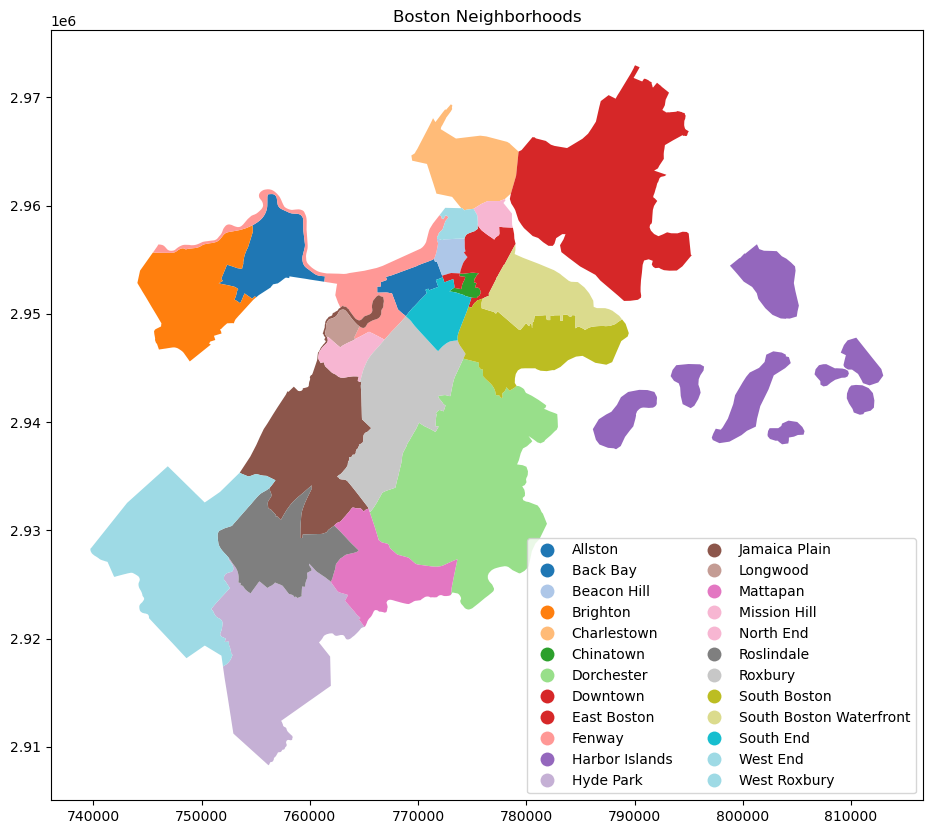

In [4]:
census.plot(column="BlockGr202", categorical=True, legend=True, cmap="tab20", figsize=(20, 10),
            legend_kwds={"loc": "lower right", "ncol": 2})
plt.title('Boston Neighborhoods')
plt.show()

#### Approved dataset

In [5]:
abp = pd.read_csv("../data/cleaned_abp.csv")
abp.dropna(subset=["lon", "lat"], inplace=True)

Estimated runtime 19 seconds.

Number of points 607822


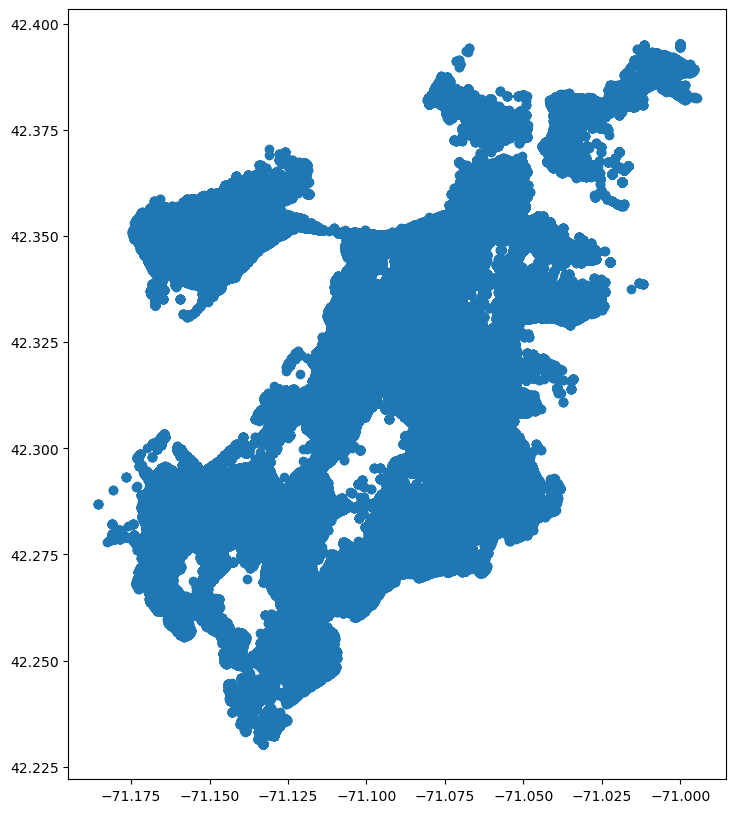

In [6]:
gabp = gpd.GeoDataFrame(
    abp, geometry=gpd.points_from_xy(abp["lon"], abp["lat"], crs="EPSG:4326")
)
gabp.plot(figsize=(15, 10))
print(f'Number of points {gabp["geometry"].count()}')

#### Article 80  dataset

In [7]:
a80 = pd.read_csv("../data/cleaned_a80.csv")
a80.dropna(subset=["lon", "lat"], inplace=True)

In [8]:
ga80 = gpd.GeoDataFrame(
    a80, geometry=gpd.points_from_xy(a80["lon"], a80["lat"], crs="EPSG:4326")
)
print(f'Number of points {ga80["geometry"].count()}')

Number of points 1762


Colormap for block groups as individual colors

In [10]:
import distinctipy
n = census["BlockGr202"].count()
colors = distinctipy.get_colors(n, n_attempts=10)
cmap = distinctipy.get_colormap(colors)

Filtering 

Number of points 1738


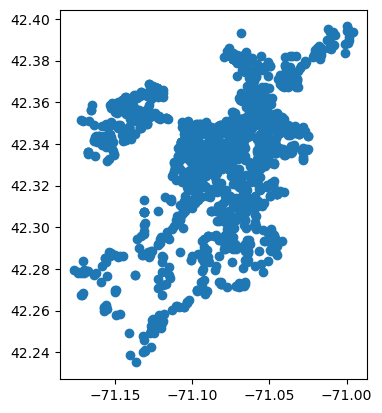

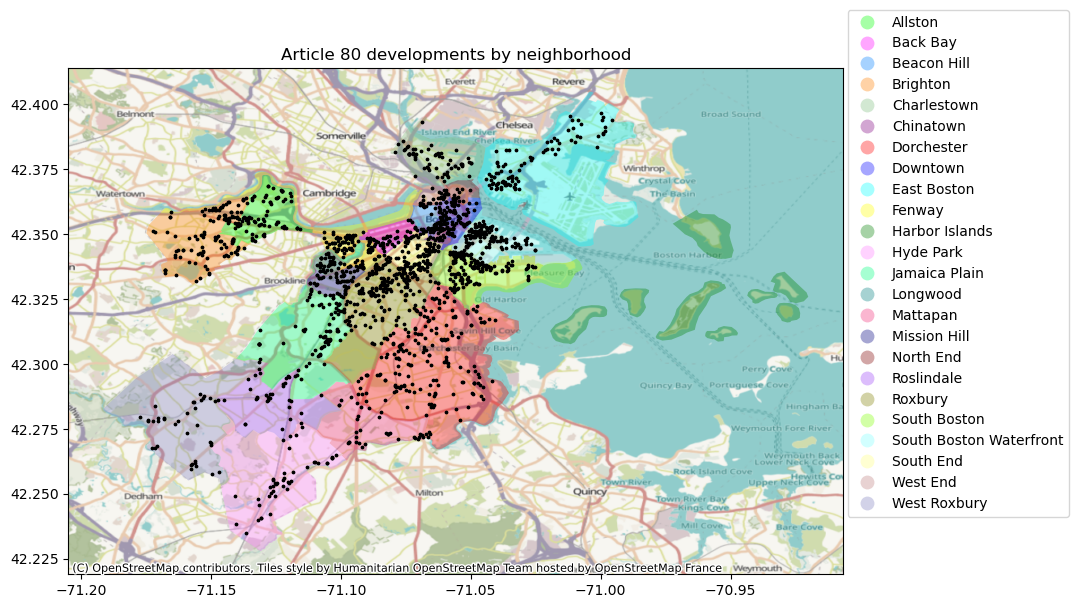

In [11]:
a80 = pd.read_csv("../data/cleaned_a80.csv")
a80.dropna(subset=["lon", "lat"], inplace=True)
cen = census.copy()
census.to_crs("EPSG:4326", inplace=True)
lat_range = (42, 43)
lon_range = (-72, -70)
f_a80 = a80[(a80['lat'] >= lat_range[0]) & (a80['lat'] <= lat_range[1]) &
                   (a80['lon'] >= lon_range[0]) & (a80['lon'] <= lon_range[1])]
fa80 = gpd.GeoDataFrame(
    f_a80, geometry=gpd.points_from_xy(f_a80["lon"], f_a80["lat"], crs="EPSG:4326")
)
fa80.plot()
fa80.to_crs(census.crs, inplace=True)
print(f'Number of points {fa80["geometry"].count()}')
ax = census.plot(column="BlockGr202", alpha=0.35, categorical=True, legend=True, cmap=cmap, figsize=(10, 10),
            legend_kwds={"loc": "lower right", "bbox_to_anchor":(1.3, 0.1)})
fa80.plot(ax=ax, markersize=3, color="k")
cx.add_basemap(ax, crs=census.crs)
ax.set_title("Article 80 developments by neighborhood")
plt.savefig("a80", bbox_inches='tight')

In [12]:
# clean memory
del ga80, a80, abp

In [13]:
# Change coordinate system so geometries can be overlayed
gabp.to_crs(census.crs, inplace=True)

Approved dataset vs neighborhoods

<Axes: >

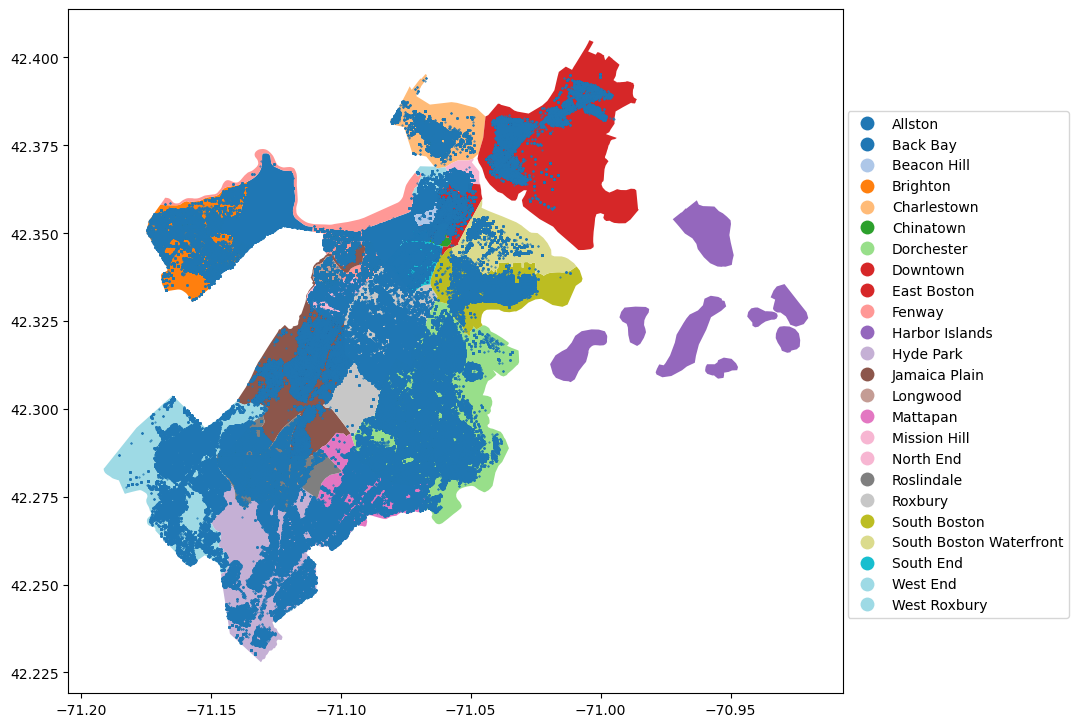

In [14]:
ax = census.plot(column="BlockGr202", categorical=True, legend=True, cmap="tab20", figsize=(10, 10),
            legend_kwds={"loc": "lower right", "bbox_to_anchor":(1.3, 0.1)})
gabp.plot(ax=ax, markersize=0.2)

#### Spacial join

In [15]:
num_per_neighborhood = census.sjoin(gabp, predicate="contains").groupby("BlockGr202").size()
num_per_neighborhood["Harbor Islands"] = 0
num_per_neighborhood.head()

BlockGr202
Allston        13908
Back Bay       43429
Beacon Hill    13145
Brighton       25547
Charlestown    20618
dtype: int64

#### Attribute join development count column with census neighborhoods by index

In [16]:
census = census.merge(num_per_neighborhood.rename("point counts"), left_on="BlockGr202", right_on=num_per_neighborhood.index)

<Axes: >

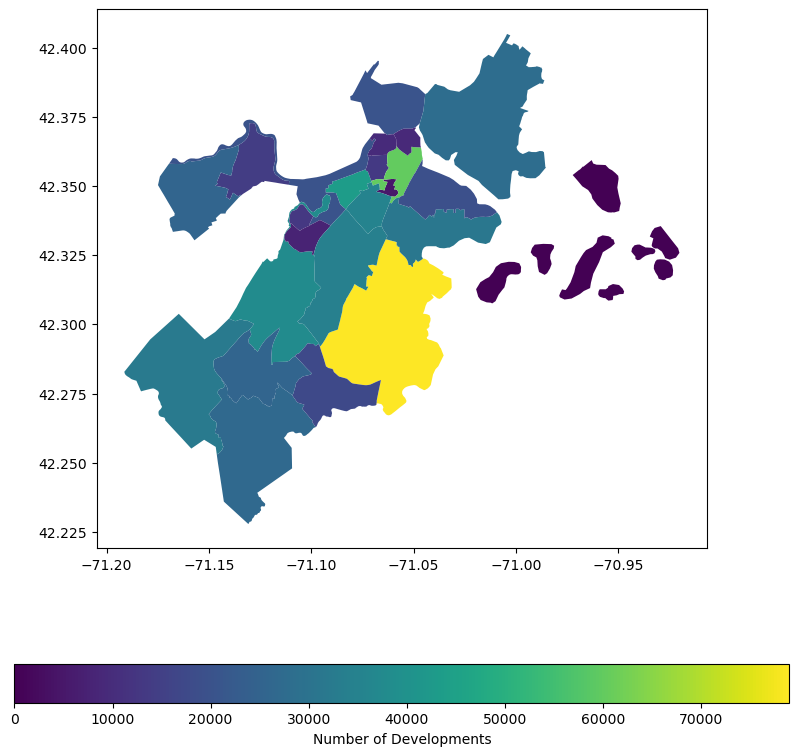

In [17]:
census.plot(column="point counts", legend=True, cmap="viridis", figsize=(10, 10),\
                     legend_kwds={'label': "Number of Developments",
                         'orientation': "horizontal"})

In [18]:
# Adjust index
num_per_neighborhood.index = [i if i != "South Boston Waterfront" else "S. Boston Waterfront" for i in num_per_neighborhood.index]

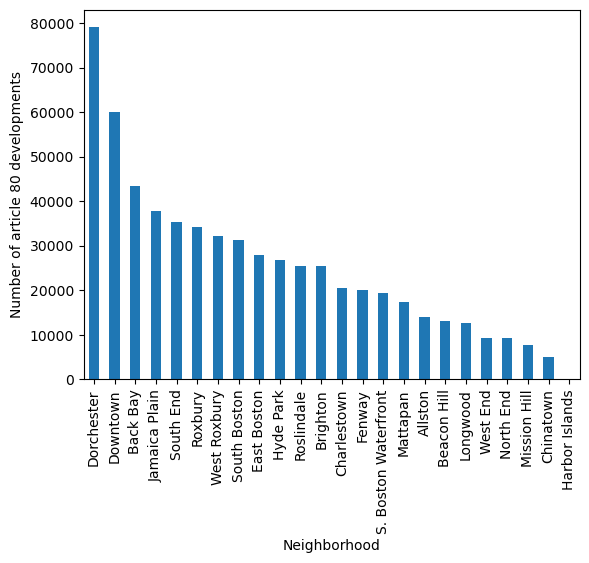

In [19]:
ax = num_per_neighborhood.sort_values(ascending=False).plot(kind="bar")
ax.set_xlabel("Neighborhood")
ax.set_ylabel("Number of article 80 developments")
plt.savefig("nums_neighborhoods", bbox_inches='tight')

In [20]:
# Transform to Web Mercador coordinate system
census.to_crs(epsg=3857, inplace=True)
gabp.to_crs(epsg=3857, inplace=True)

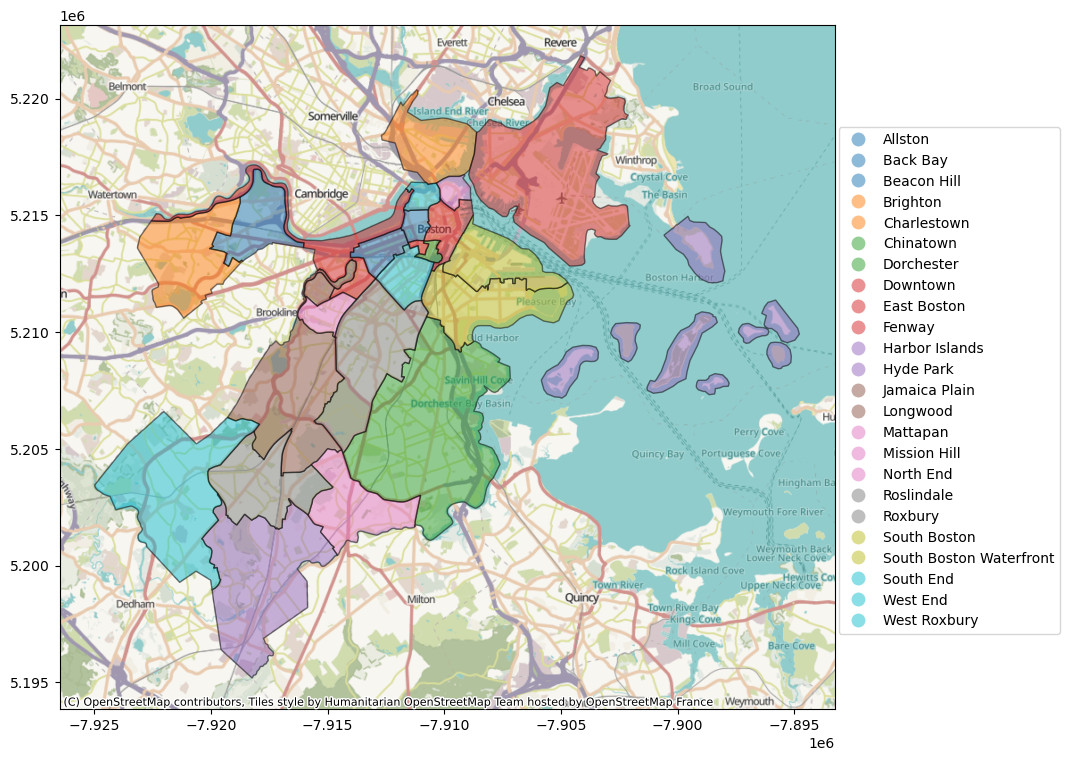

In [21]:
ax = census.plot(figsize=(10, 10), alpha=0.5, edgecolor="k",  column="BlockGr202",
                 legend=True, legend_kwds={"loc": "lower right", "bbox_to_anchor":(1.3, 0.1)})
cx.add_basemap(ax, crs=census.crs)


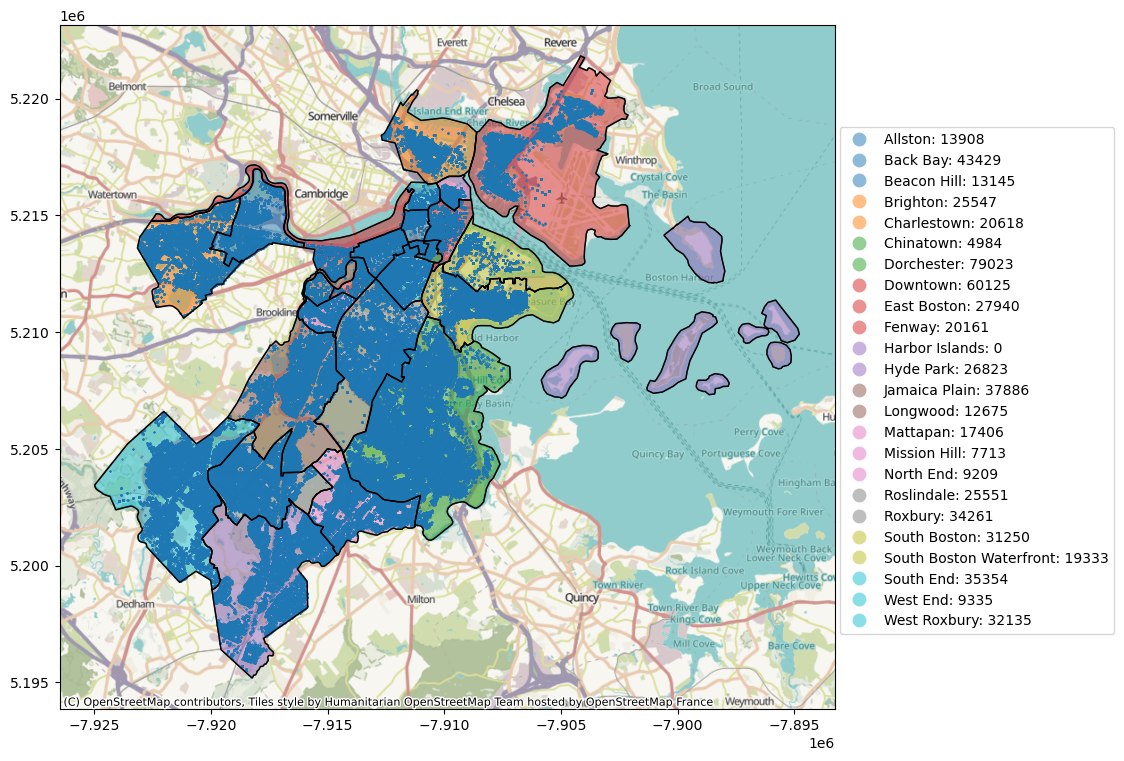

In [22]:
census["labels"] = census["BlockGr202"] + ": " + census["point counts"].apply(str)
ax = census.plot(figsize=(10, 10), alpha=0.5, edgecolor="k", column="BlockGr202",
                 legend=True, legend_kwds={"loc": "lower right", "bbox_to_anchor":(1.37, 0.1),                                    
                                           "labels": census["labels"].to_list()})
gabp.plot(ax=ax, markersize=0.1)
census.plot(ax=ax, facecolor="none", edgecolor="k")
cx.add_basemap(ax, crs=census.crs)

In [23]:
# Spacial join points to neighborhood (within relationship)
gabp["Neighborhood"] = gabp.sjoin(census, predicate="within")["BlockGr202"]

In [24]:
num_per_neighborhood["Harbor Islands"] = 0

In [25]:
census = census.merge(num_per_neighborhood.rename("Development counts"), left_on="BlockGr202", right_on=num_per_neighborhood.index)

<Axes: >

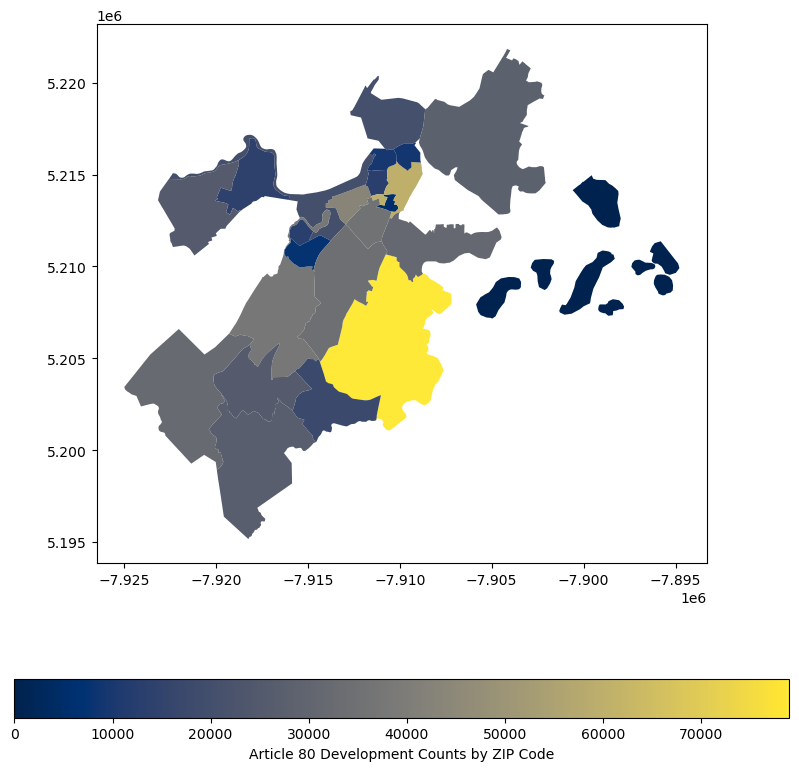

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
census.plot(column="Development counts", ax=ax, legend=True, cmap="cividis",\
                     legend_kwds={'label': "Article 80 Development Counts by ZIP Code",
                         'orientation': "horizontal"})

In [27]:
census["point counts"].sum()

588478

#### Census block group data

In [28]:
census_bg = gpd.read_file('../data/census_block_groups/2020_Census_Block_Groups_in_Boston.shp')

In [29]:
gdata = pd.read_csv("../data/census-block-group-data.csv")
cols = "field concept,State/US-Abbreviation (USPS),Summary Level,Geographic Record Identifier,Geographic Code Identifier,Region,Division,State (FIPS),County (FIPS),County Subdivision (FIPS),Census Tract,Block Group,GEOID 2020 block group,Total:,White alone,Black or African American alone,Hispanic or Latino,Asian alone,American Indian and Alaska Native alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Population of two or more races:,Total:,White alone,Black or African American alone,Hispanic or Latino,Asian alone,American Indian and Alaska Native alone,Native Hawaiian and Other Pacific Islander alone,Some Other Race alone,Population of two or more races:,Total:,Institutionalized population:,Correctional facilities for adults,Juvenile facilities,Nursing facilities/Skilled-nursing facilities,Other institutional facilities,Noninstitutionalized population:,College/University student housing,Military quarters,Other noninstitutional facilities,Total:,Occupied,Vacant"\
        .split(",")
mapper = {old: new for old, new in zip(gdata.columns, cols)}
gdata.rename(columns=mapper, inplace=True)

<Axes: >

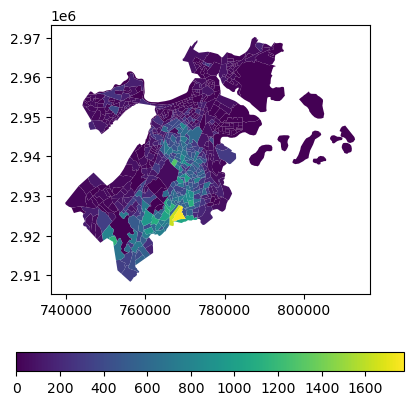

In [30]:
gdata["geoid20"] = gdata["Geographic Record Identifier"].str.split("US").apply(lambda x: x[1])
census_combined = census_bg.merge(gdata, on="geoid20")
census_combined["Black or African American alone"]
census_unique = census_combined.loc[:,~census_combined.columns.duplicated()].copy() # make new dataframe with unique columns names
census_unique.plot(column="Black or African American alone", legend=True, legend_kwds=dict(orientation="horizontal"), figsize=(5, 5))

In [31]:
gabp.to_crs(census_unique.crs, inplace=True)
num_per_bg = census_unique.sjoin(gabp, predicate="contains").groupby("geoid20").size()

In [32]:
census_unique = census_unique.merge(num_per_bg.rename("dev counts"), how="left", left_on="geoid20", right_on=num_per_bg.index)

In [33]:
census_unique["dev counts"].fillna(0, inplace=True)
census_unique["dev counts"].isna().sum()

0

Development counts by census block group

<Axes: >

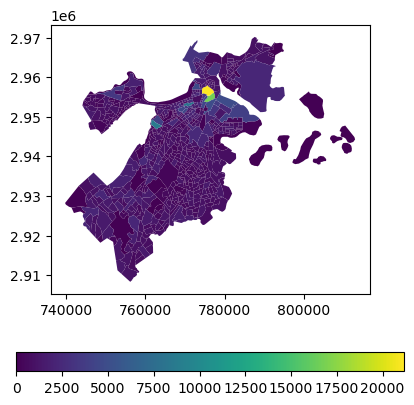

In [34]:
census_unique.plot(column="dev counts", legend=True, legend_kwds=dict(orientation="horizontal"), figsize=(5, 5))

####  Demographic group Lorenz curves and Gini coefficients

In [35]:
sums = {col: census_unique[col].sum() for col in ["Total:", "dev counts"]}
sums

{'Total:': 675647, 'dev counts': 607708.0}

Total

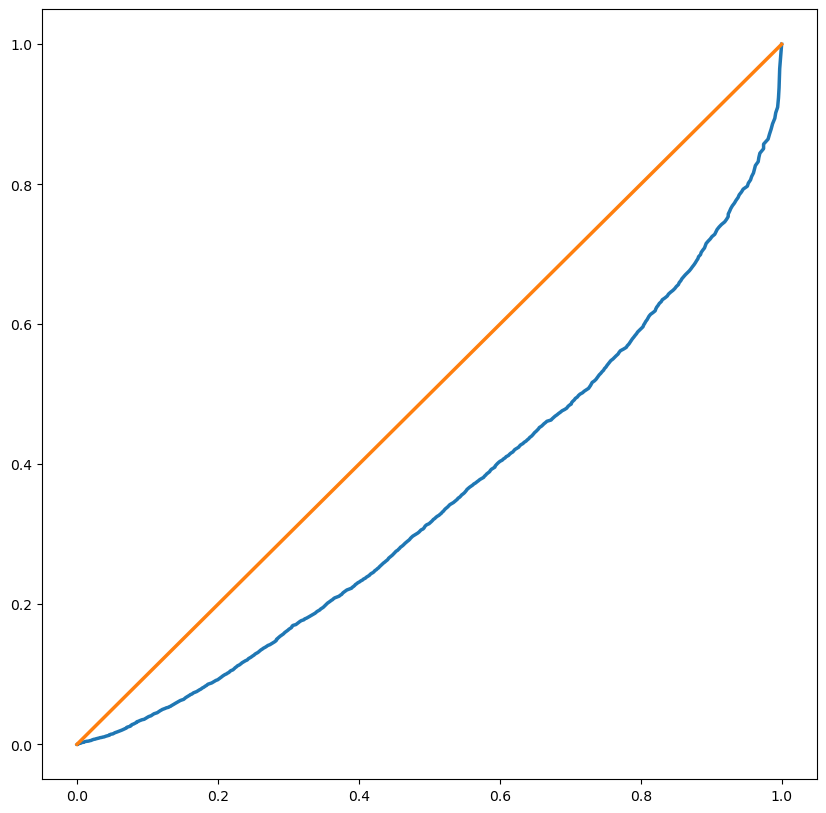

In [36]:
census_unique.sort_values(by="dev counts", ascending=True, inplace=True)
sum_pop, sum_dev = 0, 0
ratios_pop, ratios_dev = [], []
for i, row in census_unique.iterrows():
    sum_pop += row["Total:"]
    sum_dev += row["dev counts"]
    r_pop = sum_pop / sums["Total:"]
    r_dev = sum_dev / sums["dev counts"]
    ratios_pop.append(r_pop)
    ratios_dev.append(r_dev)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ratios_pop, ratios_dev, label="equal", linewidth=2.5)
# ax.scatter(ratios_pop, ratios_dev)
ax.plot(ratios_pop, ratios_pop, label="actual", linewidth=2.5)
# ax.scatter(ratios_pop, ratios_pop)

In [37]:
from sklearn.metrics import auc
lorenz = auc(ratios_pop, ratios_dev)
full = 0.5
gini = (full - lorenz) / full
gini

0.3025270833377619

Relatively equal 

In [38]:
race_cols = [ "Total:", 'White alone',
       'Black or African American alone', 'Hispanic or Latino', 'Asian alone',
       'American Indian and Alaska Native alone',
       'Native Hawaiian and Other Pacific Islander alone',
       'Some Other Race alone', 'Population of two or more races:']
sums_r = {col: census_unique[col].sum() for col in ["dev counts"] + race_cols}
sums_r

{'dev counts': 607708.0,
 'Total:': 675647,
 'White alone': 301464,
 'Black or African American alone': 129264,
 'Hispanic or Latino': 126113,
 'Asian alone': 75588,
 'American Indian and Alaska Native alone': 989,
 'Native Hawaiian and Other Pacific Islander alone': 251,
 'Some Other Race alone': 9257,
 'Population of two or more races:': 32721}

Total:: 0.303
White alone: 0.181
Black or African American alone: 0.446
Hispanic or Latino: 0.409
Asian alone: 0.335
American Indian and Alaska Native alone: 0.409
Native Hawaiian and Other Pacific Islander alone: 0.455
Some Other Race alone: 0.392
Population of two or more races:: 0.341


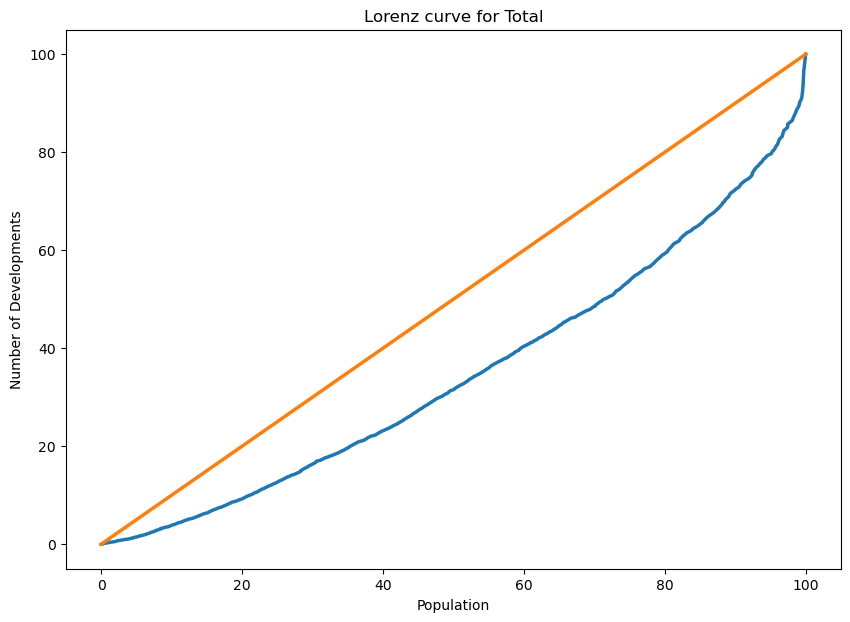

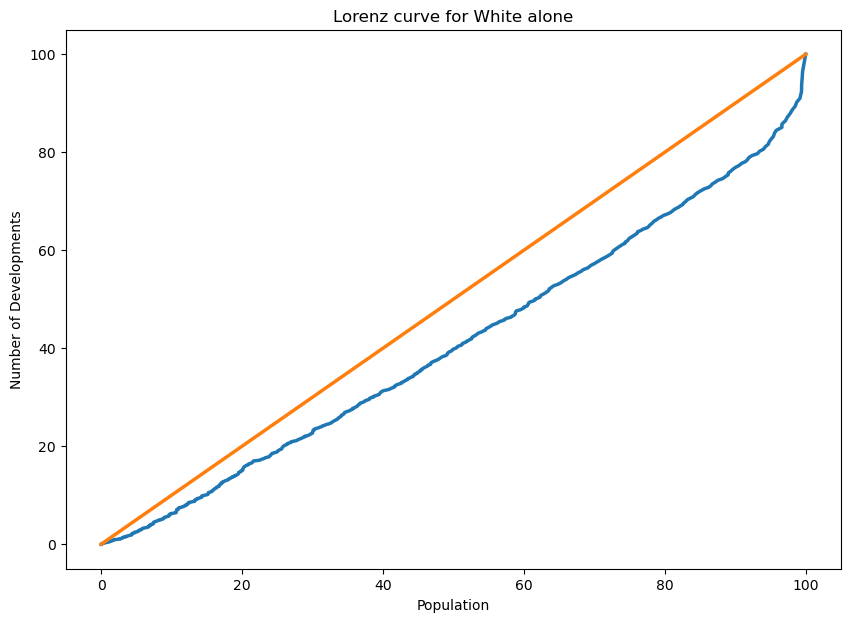

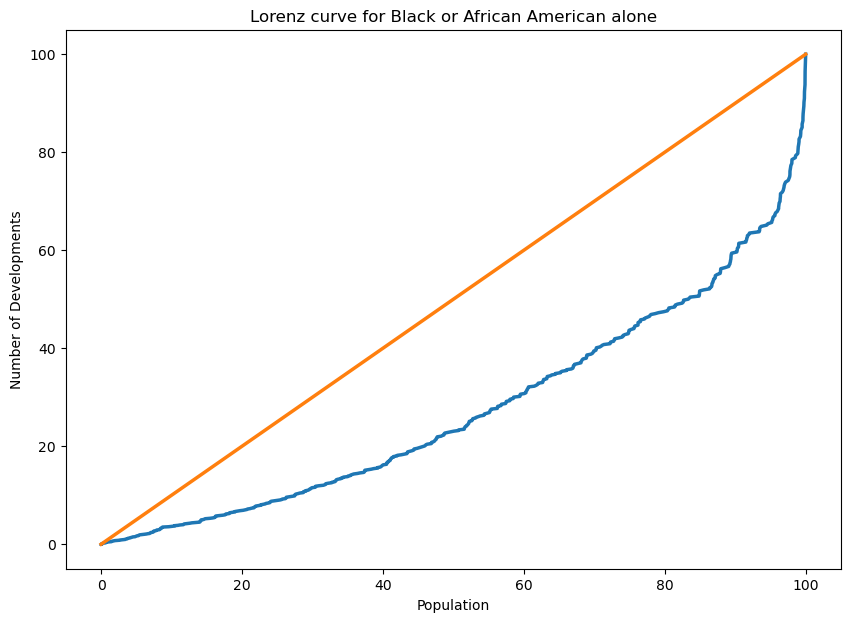

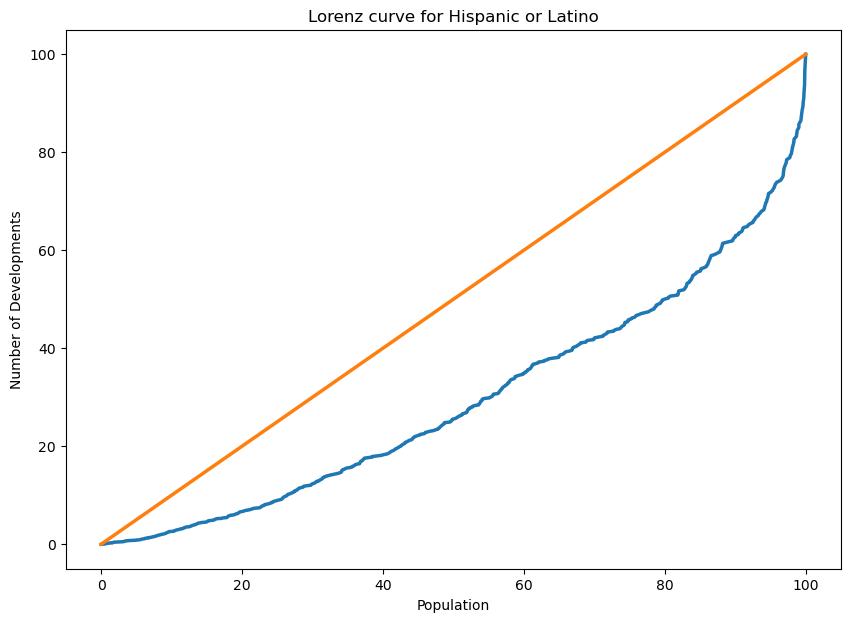

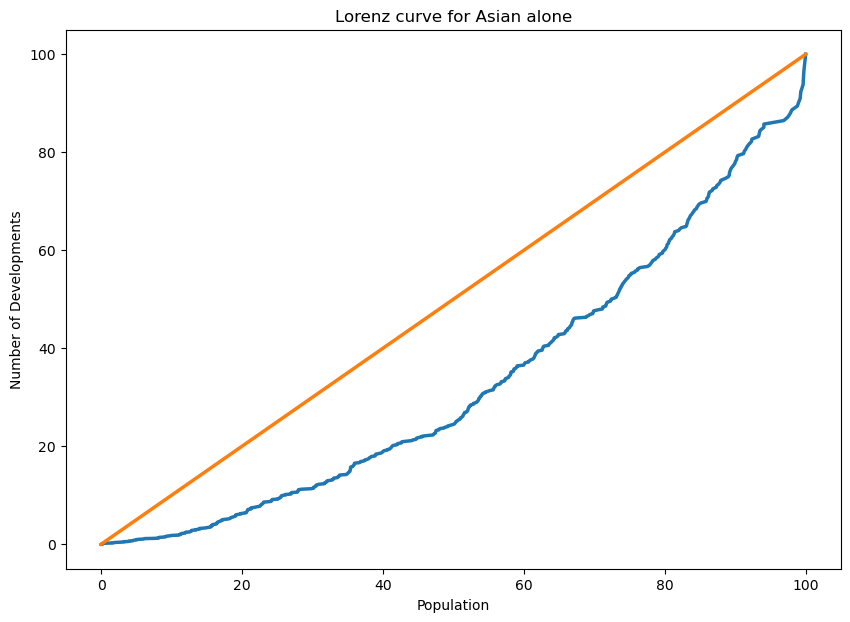

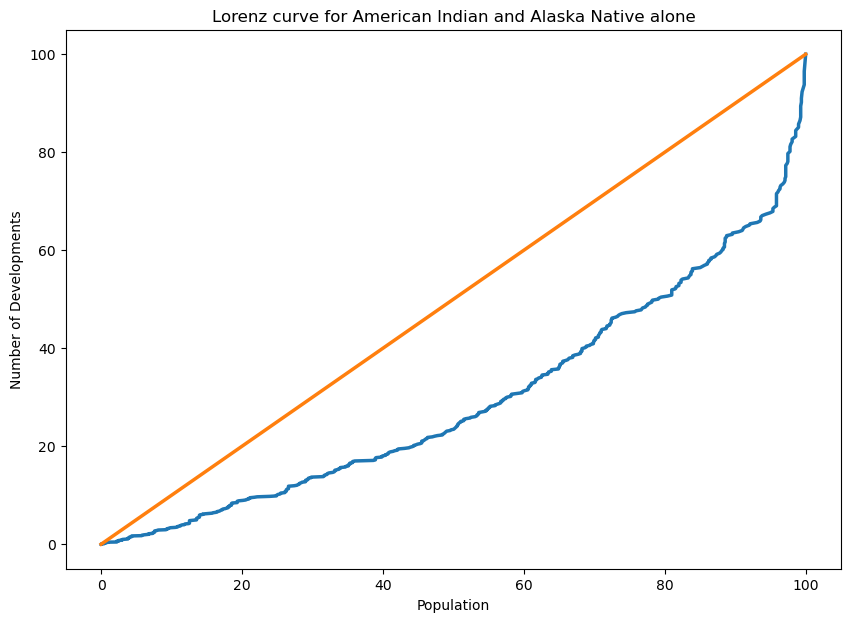

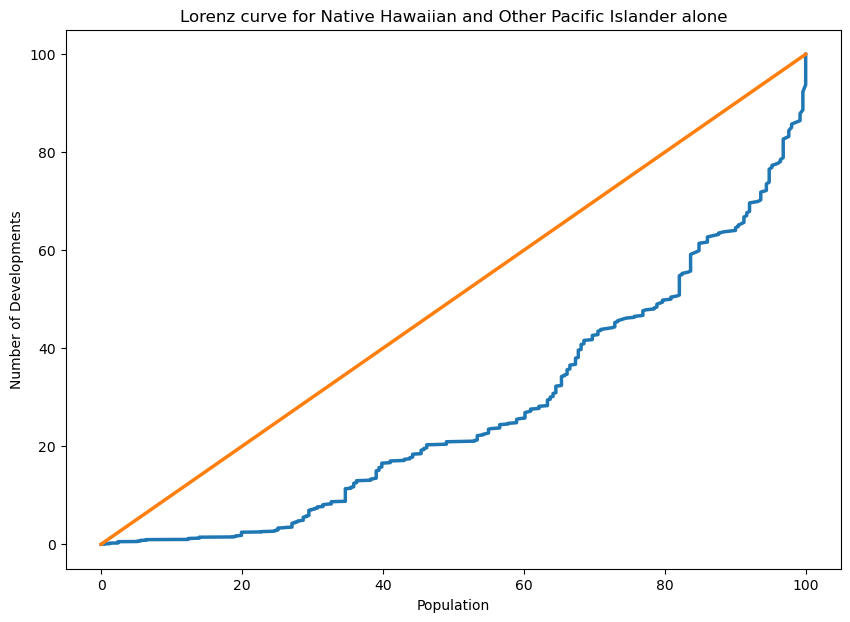

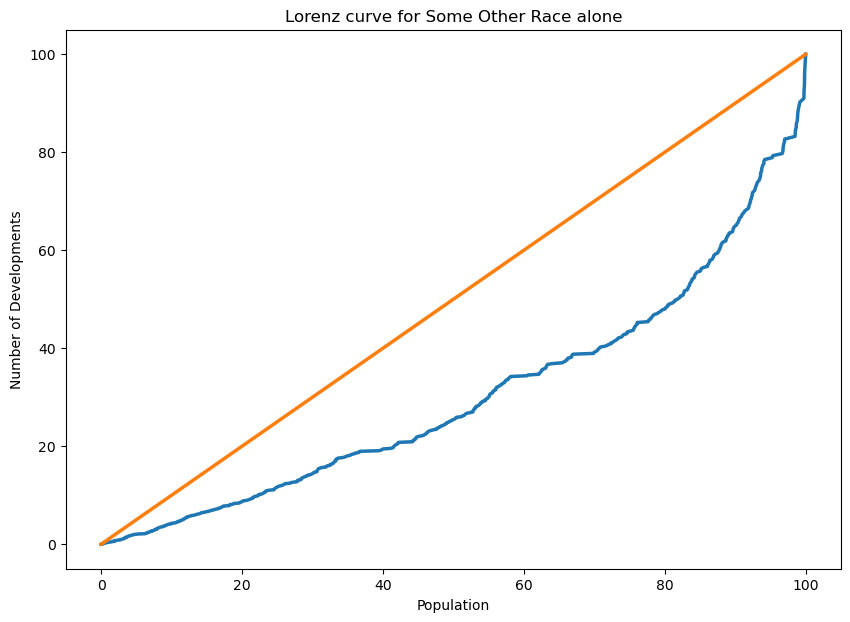

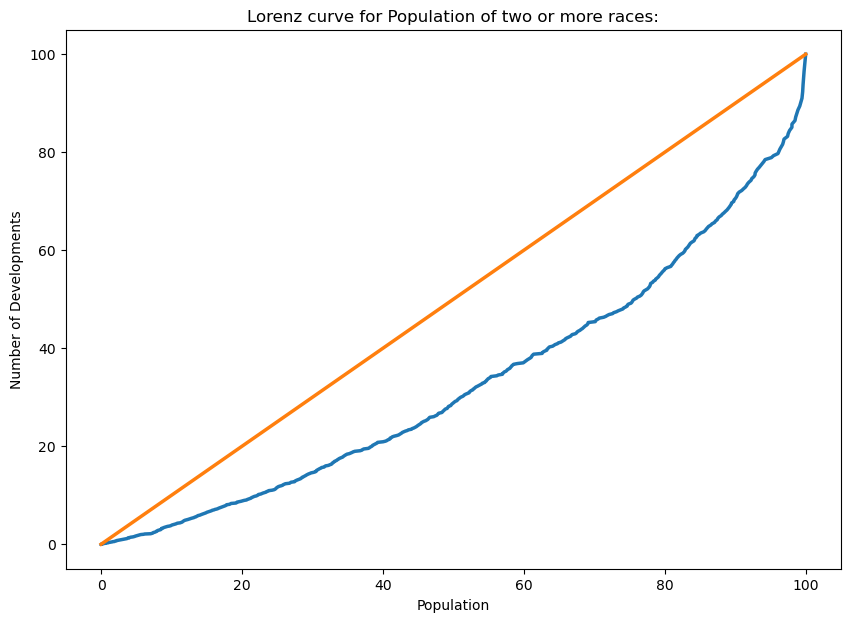

In [39]:
census_unique.sort_values(by="dev counts", ascending=True, inplace=True)
l_curves = {col: {} for col in race_cols}
for col in race_cols:
    sum_pop, sum_dev = 0, 0
    ratios_pop, ratios_dev = [], []
    for i, row in census_unique.iterrows():
        sum_pop += row[col]
        sum_dev += row["dev counts"]
        r_pop = sum_pop / sums_r[col]
        r_dev = sum_dev / sums_r["dev counts"]
        ratios_pop.append(r_pop * 100)
        ratios_dev.append(r_dev * 100)
    l_curves[col]["pop"] = ratios_pop
    l_curves[col]["dev"] = ratios_dev
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.plot(ratios_pop, ratios_dev, label="equal", linewidth=2.5)
    ax.plot(ratios_pop, ratios_pop, label="actual", linewidth=2.5)
    ax.set_title(f"Lorenz curve for {col if col != 'Total:' else col[:-1]}")
    lorenz = auc(ratios_pop, ratios_dev)
    full = 5000
    gini = (full - lorenz) / full
    print(f"{col}: {round(gini, 3)}")
    l_curves[col]["gini"] = gini
    ax.set_xlabel(f"Population")
    ax.set_ylabel(f"Number of Developments")